# TP : Word Embeddings for Classification

## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task. 
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import gzip
pp = pprint.PrettyPrinter(indent=3)

## Loading data

Let's load the data: take a first look.

In [2]:
with open("rncp.csv", encoding='utf-8') as f:
    rncp = pd.read_csv(f, na_filter=False)

print(rncp.head())

   Categorie                                text_certifications
0          1  Responsable de chantiers de bûcheronnage manue...
1          1  Responsable de chantiers de bûcheronnage manue...
2          1                                 Travaux forestiers
3          1                                              Forêt
4          1                                              Forêt


In [3]:
print(rncp.columns.values)
texts = rncp.loc[:,'text_certifications'].astype('str').tolist()
labels = rncp.loc[:,'Categorie'].astype('str').tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity: 

In [4]:
Categories = ["1-environnement",
              "2-defense",
              "3-patrimoine",
              "4-economie",
              "5-recherche",
              "6-nautisme",
              "7-aeronautique",
              "8-securite",
              "9-multimedia",
              "10-humanitaire",
              "11-nucleaire",
              "12-enfance",
              "13-saisonnier",
              "14-assistance",
              "15-sport",
              "16-ingenierie"]

In [5]:
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


In [6]:
# This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 1
texts_reduced = texts[0::k]
labels_reduced = labels[0::k]

print('Number of documents:', len(texts_reduced))

Number of documents: 94312


Use the function ```train_test_split```from ```sklearn``` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>

In [7]:
from sklearn.model_selection import train_test_split
prop = 1 / 5
random_state = 42
texts_reduced, test_texts, labels_reduced, test_labels = train_test_split(texts,
                                                                          labels,
                                                                          test_size= prop,
                                                                          random_state = random_state)

## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words). Complete the following function, using the appropriate ```nltk``` tools. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [8]:
# Imports
import nltk
import string
from nltk import stem, word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')


def remove_punctuation(sentence: str ) -> str:
    filtered_words = [word for word in sentence.split() if word not in string.punctuation]
    return " ".join(filtered_words)

def lowercase(sentence: str) -> str:
    return sentence.lower()

def remove_stopwords(sentence: str, language) -> str:
    stopwords = nltk.corpus.stopwords.words(language)
    filtered_words = [word for word in sentence.split() if word not in stopwords]
    return " ".join(filtered_words)

def remove_extra_whitespace(sentence: str) -> str:
    sentence = sentence.strip()
    return sentence

def stemming(sentence: str) -> str:
    stemmer = stem.RegexpStemmer('s$|es$|era$|erez$|ions$| <etc> ')
    filtered_words = [stemmer.stem(word) for word in sentence.split()]
    return " ".join(filtered_words)

def strip(sentence: str) -> str:
    return sentence.strip()

def preprocessing(sentence, language = "french") -> str:
    """
    Simple preprocessing
    """
    return  " ".join(
        word_tokenize(
            stemming(
                remove_stopwords(
                    remove_punctuation(
                        lowercase(
                            strip(
                                sentence
                            )
                        )
                    ),
                    language = language
                )
            )
        )
    )

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pcd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pcd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\pcd\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


<div class='alert alert-block alert-info'>
            Code:</div>

In [9]:
# Look at the data and apply the appropriate pre-processing
texts_reduced, test_texts = [preprocessing(s) for s in texts_reduced],\
                             [preprocessing(s) for s in test_texts]

Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
from typing import Tuple, Dict

def create_vocabulary(texts) -> Tuple[Dict[str, int], np.ndarray]:
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    vocabulary_set = set()
    [vocabulary_set.add(word) for text in texts for word in text.split()]
    vocabulary= {word: index for index, word in enumerate(vocabulary_set)}
    return vocabulary

In [11]:
vocabulary = create_vocabulary(texts_reduced)

In [12]:
print(f"Size of the vocabulary : {len(vocabulary)}")

Size of the vocabulary : 6215


In [13]:
len(texts_reduced)

75449

What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

<div class='alert alert-block alert-warning'>
            Question: We need to reduce the size of the vocabulary,
            firstly in memory this vocabulary create issue in memory
            because when I ran the program, some lag appears because the memory of my system is very used to store
            the vocabulary
            We can set up a min_df which is the number minimal of occurences that a word need to be in the vocabulary to reduce the number of words</div>

## 2 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics``` 

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [14]:
from typing import List
def create_representations(vectorizer: object,
                           texts_train: List[str],
                           texts_test: List[str]) -> Tuple[np.ndarray] :
    X_train = vectorizer.fit_transform(texts_train).toarray()
    X_test = vectorizer.transform(texts_test).toarray()
    return X_train, X_test

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(vocabulary = vocabulary)
X_train_c, X_test_c = create_representations(count_vectorizer, texts_reduced, test_texts)

In [16]:
vocabulary_train = count_vectorizer.vocabulary_

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def pipeline_model(X_train: np.ndarray,
                   y_train: np.ndarray,
                   X_test: np.ndarray,
                   y_test: np.ndarray,
                   hyperparams:Dict[str,object]) -> Dict[str,object] :
    results = {}
    model = LogisticRegression(**hyperparams)
    model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)
    test_conf_matrix = confusion_matrix(y_test, predictions_test)
    train_accuracy = accuracy_score(y_train, predictions_train)
    test_accuracy = accuracy_score(y_test, predictions_test)
    results['test_confusion_matrix'] = test_conf_matrix
    results['train_accuracy'] = train_accuracy
    results['test_accuracy'] = test_accuracy
    return results

In [18]:
hyperparams_0 = {
    "max_iter" : 300
}

In [19]:
results_c = pipeline_model(X_train_c,
                         labels_reduced,
                         X_test_c,
                         test_labels,
                         hyperparams = hyperparams_0)

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def print_results(results : Dict[str, object]) -> None:
    ConfusionMatrixDisplay(results_c["test_confusion_matrix"]).plot()
    print(f'''
        Training Accuracy :  {results["train_accuracy"]},
        Test Accuracy : {results["test_accuracy"]}
    ''')
    plt.show()


The confusion matrix


        Training Accuracy :  0.3287783800978144,
        Test Accuracy : 0.24640831256958065
    


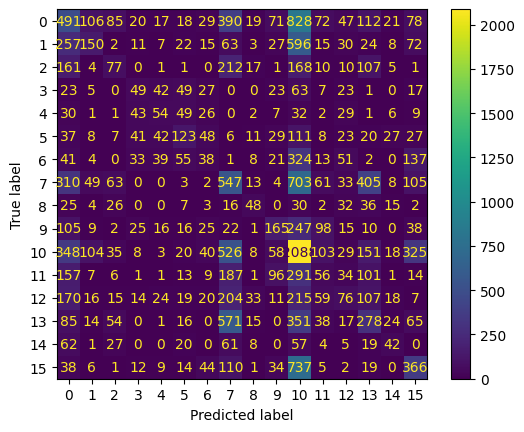

In [ ]:
print_results(results_c)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(vocabulary = vocabulary)
X_train_t, X_test_t = create_representations(tfidf, texts_reduced, test_texts)

In [ ]:
results_t = pipeline_model(X_train_t,
                           labels_reduced,
                           X_test_t,
                           test_labels,
                           hyperparams = hyperparams_0)


        Training Accuracy :  0.32506726397964186,
        Test Accuracy : 0.25939670253936276
    


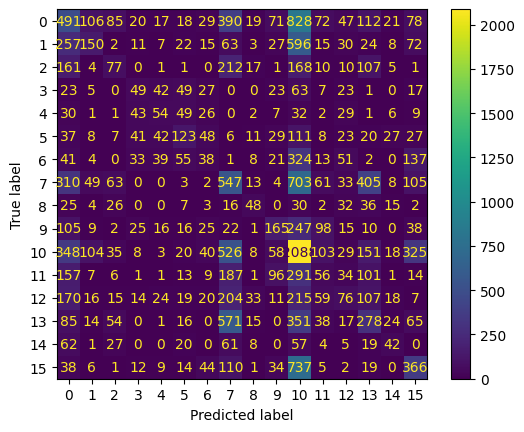

In [ ]:
print_results(results_t)

## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
Code:</div>

In [ ]:
from sklearn.decomposition import TruncatedSVD
n_components = 300
tsvd = TruncatedSVD(n_components = n_components)

In [ ]:
Xsvd_train = tsvd.fit_transform(X_train_t)

In [ ]:
Xsvd_test = tsvd.transform(X_test_t)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda= LatentDirichletAllocation(n_components = n_components)
Xlda_train = lda.fit_transform(X_train_t)

In [ ]:
Xlda_test = lda.transform(X_test_t)

In [ ]:
results_tsvd = pipeline_model(Xsvd_train,
                           labels_reduced,
                           Xsvd_test,
                           test_labels,
                           hyperparams = hyperparams_0)


        Training Accuracy :  0.2808254582565707,
        Test Accuracy : 0.26475110003710967
    


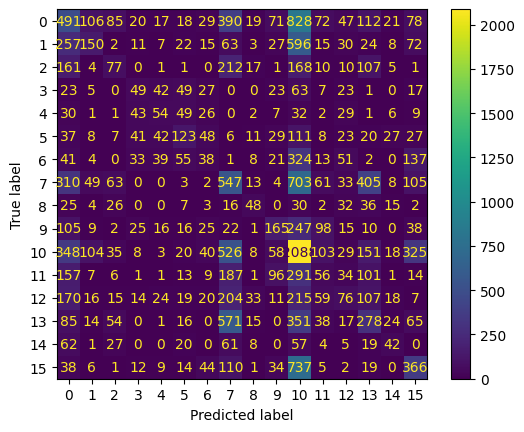

In [ ]:
print_results(results_tsvd)

In [ ]:
results_lda = pipeline_model(Xlda_train,
                              labels_reduced,
                              Xlda_test,
                              test_labels,
                              hyperparams = hyperparams_0)


        Training Accuracy :  0.2034884491510822,
        Test Accuracy : 0.2048454646662779
    


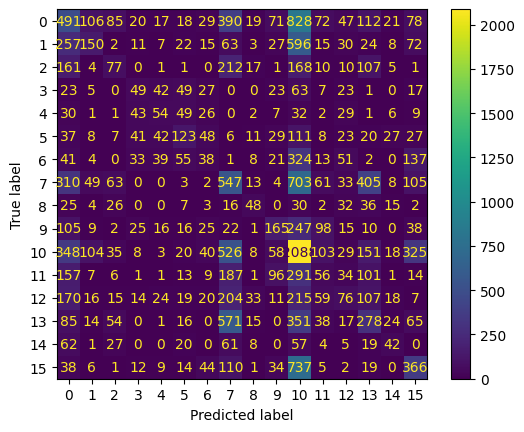

In [ ]:
print_results(results_lda)

<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ? 

<div>
We need for each hyperparameter lambda of the model, compute the distance between the original matrix X and the matrix computed by the model
we consider a set of hyperparameters and perform a grid search selection and we choose the best hyperparameter $p_{opt}$ such that the minimal distance between
the original matrix X and the matrix computed by the model is realized by $p_{opt}$  </div>

## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs. 

Some instructions:
- In step 1, use the ```co_occurence_matrix``` function, which you need to complete.
- In step 2, use ```TruncatedSVD```to obtain word representations of dimension $300$ from the output of the ```co_occurence_matrix``` function.
- In step 3, use the ```sentence_representations``` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the *training data co-occurence matrix* only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.

In [ ]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence
        sent = " ".join(sent)
        # Obtain the indexes of the words in the sentence from the vocabulary
        sent_idx = [vocabulary[word] for word in sent.split()]

        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
                sent_idx.append(len(vocabulary)-1) # This adds an Unkown word to the sentence
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = [sent_idx[i - k] for k in range(1, window + 1) if i-k >= 0]
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = [sent_idx[k] for k in range(i)]
            # Go through the list and update M[i,j] and M[j,i]:        
            for j, ctx_idx in enumerate(l_ctx_idx):
                M[idx, ctx_idx] += 1
                M[ctx_idx,idx] = M[idx,ctx_idx]
    return M

In [ ]:
def ppmi_matrix(M:np.ndarray, eps = 1) -> np.ndarray :
    """
    :param M: co_occurence matrix
    :param eps: avoid zero in log and division
    :return: ppmi matrix same shape as M
    """
    P = np.zeros(M.shape)
    total_sum = np.sum(M)
    first_part = (total_sum * M + eps)
    second_part = (np.sum(M, axis = 1).reshape(-1, 1) \
                  @ np.sum(M, axis = 0).reshape(-1, 1).T + eps)
    return np.log(first_part / second_part)

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def reload_texts(texts: List[str], vocabulary: Dict[str, int]) -> Tuple[List[List[str]],List[int]] :
    corpus = []
    for i in range(len(texts)):
        words = [w for w in texts[i].split() if w in vocabulary.keys()]
        words = words if len(words) > 0 else []
        corpus.append(words)
    mask = [j for j in range(len(corpus)) if len(corpus[j])]
    corpus = [corpus[j] for j in range(len(corpus)) if j in mask]
    return corpus, mask

In [ ]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension
corpus_train, mask_train = reload_texts(texts_reduced, vocabulary_train)

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = []
    for text in texts:
        indexes = [vocabulary[word] for word in text.split()] # Indexes of words in the sentence obtained thanks to the vocabulary
        sentrep = np_func(embeddings[indexes, :], axis = 0) # Embeddings of words in the sentence, aggregated thanks to the function
        representations.append(sentrep)
    representations = np.array(representations)    
    return representations

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
corpus_test, mask_test = reload_texts(test_texts, vocabulary_train)

In [ ]:
def create_sentences_embeddings(M: np.ndarray,
                      corpus_train: List[str],
                      corpus_test: List[str],
                      vocabulary_train = vocabulary_train) -> Tuple[np.ndarray]:
    # Obtain document representations, apply the classifier
    words_embeddings = tsvd.fit_transform(M)
    sentences_embeddings_train = sentence_representations(corpus_train,
                                                          vocabulary_train,
                                                          words_embeddings)
    sentences_embeddings_test = sentence_representations(corpus_test,
                                                     vocabulary_train,
                                                     words_embeddings)
    return sentences_embeddings_train, sentences_embeddings_test

In [ ]:
from sklearn.preprocessing import StandardScaler
def rescale(X_train: np.ndarray, X_test: np.ndarray):
    scaler = StandardScaler() # we rescale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [ ]:
y_train = np.array(labels_reduced)[mask_train]
y_test = np.array(test_labels)[mask_test]

In [ ]:
M:np.ndarray = co_occurence_matrix(corpus_train, vocabulary_train)

In [ ]:
corpus_train_combined = [" ".join(words) for words in corpus_train]
corpus_test_combined = [" ".join(words) for words in corpus_test]

In [ ]:
X_train_co, X_test_co = rescale(*create_sentences_embeddings(M,
                                                             corpus_train_combined,
                                                             corpus_test_combined,
                                                             vocabulary_train)
                           )

In [ ]:
results_co_occurence = pipeline_model(X_train_co,
                                 y_train,
                                 X_test_co,
                                 y_test,
                                 hyperparams = hyperparams_0)


        Training Accuracy :  0.27999045712998183,
        Test Accuracy : 0.26612945978900493
    


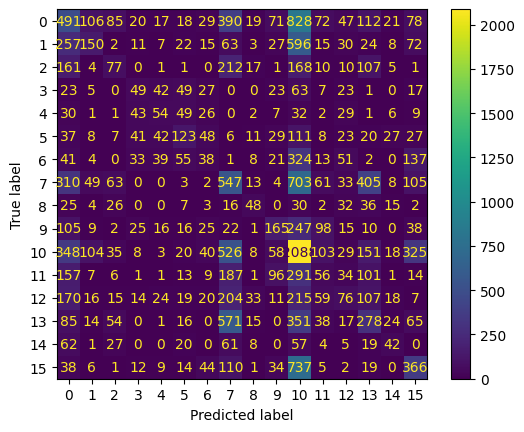

In [ ]:
print_results(results_co_occurence)

In [ ]:
M_ppmi = ppmi_matrix(M)

In [ ]:
X_train_ppmi, X_test_ppmi = rescale(*create_sentences_embeddings(M_ppmi,
                                                             corpus_train_combined,
                                                             corpus_test_combined,
                                                             vocabulary_train)
                                )

In [ ]:
results_ppmi = pipeline_model(X_train_ppmi,
                              y_train,
                              X_test_ppmi,
                              y_test,
                              hyperparams = hyperparams_0)


        Training Accuracy :  0.29054063009450093,
        Test Accuracy : 0.2724381063457562
    


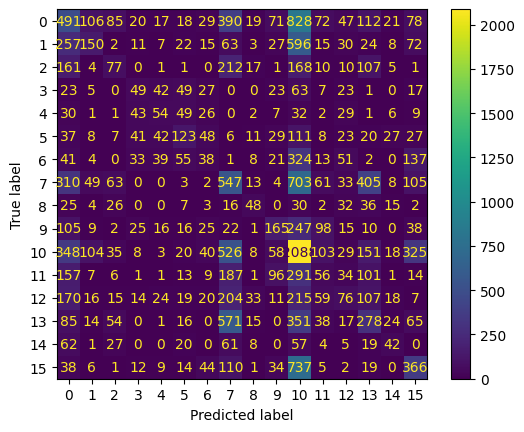

In [ ]:
print_results(results_ppmi)

We can see that with ppmi representations, we obtain better performance in training set and test set than with co-occurrence word representations
ppmi is more accurate in objective of representing context of specific word than co occurence matrix.
But the accuracy is low with two representation (~ 27.2 % of accuracy for the ppmi representations in the test set)

## 5 - Dense Prediction-based Representations

We will now use word embeddings from ```Word2Vec```: which we will train ourselves

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above.

In [ ]:
from gensim.models import Word2Vec

In [ ]:
words = list(vocabulary_train.keys())

In [ ]:
counts = np.sum(X_train_c, axis = 0).tolist()

In [ ]:
word_counts = {words[i] : counts[i] for i in range(len(words))}

In [ ]:
model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts))
model.build_vocab_from_freq(word_counts)

<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
# The model is to be trained with a list of tokenized sentences, containing the full training dataset.
preprocessed_corpus = corpus_train

In [ ]:
model.train(preprocessed_corpus,
            total_examples= len(preprocessed_corpus),
            epochs=30,
            report_delay=1)

(10920852, 21346320)

In [ ]:
embeddings_w2vec = np.vstack([model.wv[word] for word in model.wv.key_to_index])

In [ ]:
def reload_corpus_w2vec(corpus: List[List[str]], model = model) -> Tuple[List[List[str]],List[int]]:
    corpus_w2vec = [[]] * len(corpus)
    indexes = []
    for j in range(len(corpus)) :
        words = corpus[j]
        words = [w for w in words if w in model.wv.key_to_index]
        if len(words) :
            indexes.append(j)
        corpus_w2vec[j] = words
    return corpus_w2vec, indexes

In [ ]:
corpus_w2vec_train, indexes_train = reload_corpus_w2vec(corpus_train)

In [ ]:
corpus_train_w2vec_combined = [" ".join(corpus_w2vec_train[j]) for j in indexes_train]

Then, we can re-use the ```sentence_representations```function like before to obtain document representations, and apply classification. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
X_train_w2vec = sentence_representations(texts = corpus_train_w2vec_combined,
                         vocabulary = model.wv.key_to_index,
                         embeddings = embeddings_w2vec,
                         np_func=np.mean)

In [ ]:
corpus_w2vec_test, indexes_test = reload_corpus_w2vec(corpus_test)

In [ ]:
corpus_test_w2vec_combined = [" ".join(corpus_w2vec_test[j]) for j in indexes_test]

In [ ]:
X_test_w2vec = sentence_representations(texts = corpus_test_w2vec_combined,
                                         vocabulary = model.wv.key_to_index,
                                         embeddings = embeddings_w2vec,
                                         np_func=np.mean)

In [ ]:
X_train_w2vec_r, X_test_w2vec_r = rescale(X_train_w2vec, X_test_w2vec)

In [ ]:
y_train_w2vec = y_train[indexes_train]

In [ ]:
y_test_w2vec = y_test[indexes_test]

In [ ]:
hyperparams_1 = {
    "max_iter" : 500,
    "solver" : "liblinear"
}
results_w2vec = pipeline_model(X_train_w2vec_r,
                               y_train_w2vec,
                               X_test_w2vec_r,
                               y_test_w2vec,
                               hyperparams = hyperparams_1)


        Training Accuracy :  0.2899504233289472,
        Test Accuracy : 0.273481103492266
    


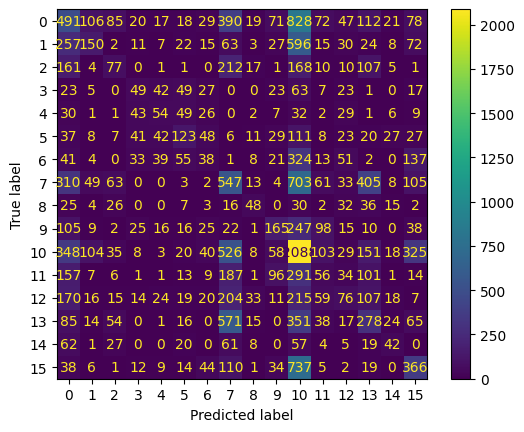

In [ ]:
print_results(results_w2vec)

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ? 
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ?

Even if you are using word embedding, we have low performance (accuracy ~27.3 % in the test set)
The big issue that embeddings did not solve is we don't consider the order of the word in the sentence
That's a big issue, the word order in the sentence is really important to capture the semantics of a sentence.
A solution is to find a deep neural network architecture that take in account the order of a word in a sentence.
With this a kind of architecture we have a word embedding that in some sense take in account the order of the word in a sentence